## Package Inclusions

In [193]:
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer, util

import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

## Reading Dataset

In [4]:
df_all_series = pd.read_json("dataset/all_series_lines.json")

## List of Series

In [39]:
df_all_series.keys()

Index(['ENT', 'DS9', 'TOS', 'TAS', 'TNG', 'VOY'], dtype='object')

## We choose a single series, DS9 i.e. Deep Space 9 for further investigation

A little bit of preliminary observation and browsing shows that 'DS9' has the least number of typos and missing space errors, making it a good quality dataset for our purposes

### Episodes

In [15]:
episodes = df_all_series['DS9'].keys()
episodes

Index(['episode 0', 'episode 1', 'episode 2', 'episode 3', 'episode 4',
       'episode 5', 'episode 6', 'episode 7', 'episode 8', 'episode 9',
       ...
       'episode 166', 'episode 167', 'episode 168', 'episode 169',
       'episode 170', 'episode 171', 'episode 172', 'episode 173',
       'episode 174', 'episode 175'],
      dtype='object', length=176)

### Characters

In [33]:
df_all_series['DS9'][episodes[0]].keys()

dict_keys(['JENNIFER', 'OPS', 'JASAD', 'PICARD', 'MAGGIE', 'DUKAT', 'BUREAUCRAT', 'CONN', 'KIRA', 'PIT', 'SISKO', 'ALIEN', 'CREWWOMAN', 'GIRL', 'CREWMAN', 'ODO', "O'BRIEN", 'ODN', 'NOG', 'OPAKA', 'CAPTAIN', 'ENSIGN', 'LOCUTUS', 'QUARK', 'CBS', 'BASHIR', 'DAX', 'COMPUTER', 'BOSS', 'OFFICER', 'JAKE', 'TACTICAL', 'CARDASSIAN', 'LIEUTENANT', 'MONK', 'BATSMAN'])

In [43]:
(df_all_series['DS9'][episodes[0]]['JENNIFER'])

['Hey!',
 'Yes?',
 "I'm sorry did we meet last night at George's party?",
 'Are you okay?',
 'We met here before?',
 "I'm afraid I don't accept drinks from strange men on thebeach.",
 'So tell me the truth. Have we really meet before?',
 'Then how did you know my name?',
 'Are you going to tell me your name?',
 'Ah, a junior officer.',
 'My mother warned me to watch out for junior officers.',
 "You're awfully sure of yourself.",
 'Do you use this routine a lot with women?',
 'Sure.',
 "I don't know.",
 "I'll probably be sorry.",
 'It is corporeal. A physical entity.',
 'Linear time. what is this?',
 'Does not exist yet?',
 'Jennifer.',
 'She is part of your existence.',
 'But she is part of your existence.',
 'Lost? what is this?',
 'It is inconceivable that any species could exist in such amanner. You are deceiving us.',
 'To what? 2',
 'So you like children? 2',
 "I've heard Starfleet officers don't want families becausethey complicate their lives. 2",
 'That almost sounds like a dom

## It appears that all the lines of a character in an episode are appended in a single list keyed by the episode and character. 

## *This makes our job easier*

# Question 1. Who has the most lines? Who are the top 5?

So, to count the no. of lines for each character, we simply count the number of entries of each character across all episodes

In [50]:
line_counts = {}

for ep in episodes:

    if df_all_series['DS9'][ep] is not np.NaN:

        for character in list(df_all_series['DS9'][ep].keys()):

            curr_lines = len(df_all_series['DS9'][ep][character])

            if character in line_counts.keys():

                line_counts[character] = line_counts[character] + curr_lines

            else:
                line_counts[character] = curr_lines

## Visualizing the No. of Lines for the top 30 characters in the entire series with the most lines

<Figure size 1440x576 with 0 Axes>

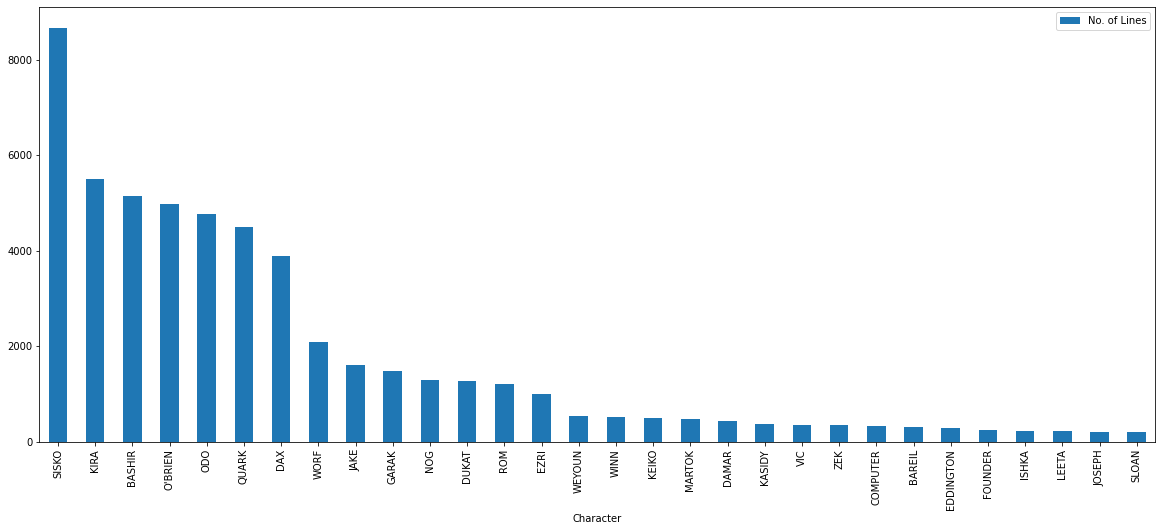

In [61]:
plt.figure(figsize = (20,8))

df_line_counts = pd.DataFrame(list(line_counts.items()), columns=['Character','No. of Lines'])
df_line_counts.sort_values(by='No. of Lines', ascending=False, inplace = True)

df_line_counts.head(30).plot.bar(x='Character',y='No. of Lines', figsize = (20,8))
plt.show()


In [63]:
print('Top 5 characters with lines: \n')
for char in df_line_counts['Character'].iloc[0:5]:
    print('\n', char)

Top 5 characters with lines: 


 SISKO

 KIRA

 BASHIR

 O'BRIEN

 ODO


### Hence, we see that the top 5 characters with the most lines are :
1. SSKO
2. KIRA
3. BASHIR
4. O'BRIEN
5. ODO


# Question 2. Who is the most verbose?
This basically means we are interested in the character who utters the most number of words. So we count the no. of words of each character.

In [65]:

word_counts = {}

for ep in episodes:

    if df_all_series['DS9'][ep] is not np.NaN:

        for character in list(df_all_series['DS9'][ep].keys()):

            curr_words = sum([len(line.split()) for line in df_all_series['DS9'][ep][character]])

            if character in word_counts.keys():

                word_counts[character] = word_counts[character] + curr_words

            else:
                word_counts[character] = curr_words


## Visualizing the No. of Words for the top 30 characters in the entire series with the most words spoken


<Figure size 1440x576 with 0 Axes>

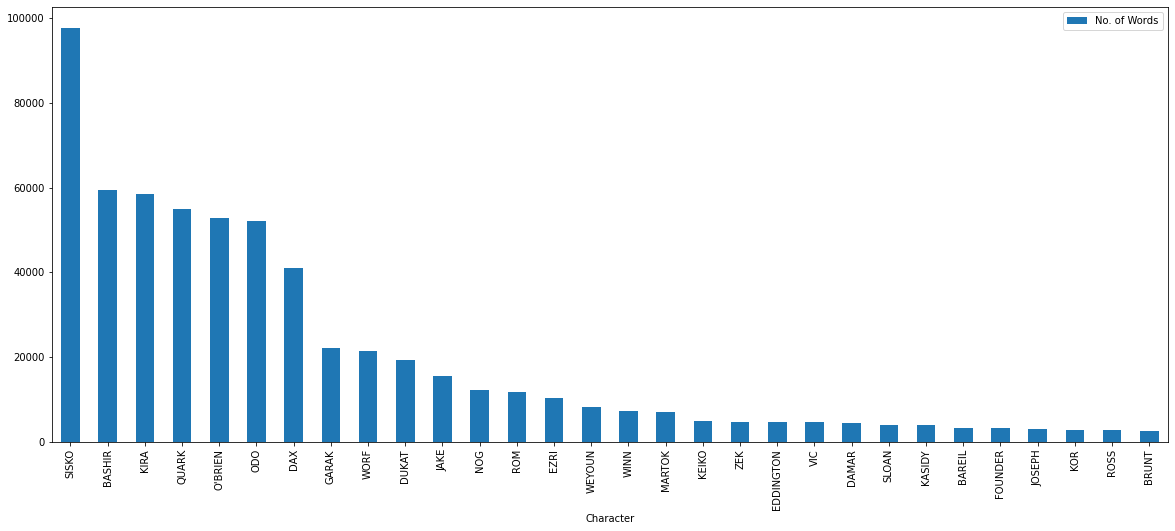

In [70]:

plt.figure(figsize = (20,8))

df_word_counts = pd.DataFrame(list(word_counts.items()), columns=['Character','No. of Words'])
df_word_counts.sort_values(by='No. of Words', ascending=False, inplace = True)

df_word_counts.head(30).plot.bar(x='Character',y='No. of Words', figsize = (20,8))
plt.show()




In [71]:
print('The most verbose character is: \n')
print(df_word_counts['Character'].iloc[0])

The most verbose character is: 

SISKO


### Hence, SISKO is the most verbose character

# Question 3. What are the main topics each main character talks about? Define how you determined main character.

### If we notice the bar plots above, we notice that there is a sharp fall in number of lines/words for characters beyond **'DAX'**
Hence, we assume there are **7 Main Characters** :
1. SSKO
2. KIRA
3. BASHIR
4. O'BRIEN
5. ODO
6. QUARK
7. DAX

### Building corpus of the lines of each Main Character

In [124]:
character_corpus = dict()

for char in df_line_counts['Character'].iloc[0:7]:
    character_corpus[char] = ""

In [125]:
for character in list(character_corpus.keys()):

    for episode in episodes:

        if df_all_series['DS9'][episode] is not np.NaN:

            #print(list(df_all_series['DS9'][episode][character]))

            dialogue_list = [x for x in df_all_series['DS9'][episode][character]]
            
            for line in dialogue_list:

                character_corpus[character] += ' ' 
                character_corpus[character] += line

    character_corpus[character] = character_corpus[character].strip()

### Text Preprocessing of the Corpus of Lines of each Main Character - Stemming, Lemmatization and Stopword Removal

Function to perform the pre processing steps on the entire dataset

In [132]:
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

## Building a Dictionary with the entire dataset of the DS9 series of Star Trek

In [139]:
preprocessed_words_list = []

for ep in episodes:

    if df_all_series['DS9'][ep] is not np.NaN:

        for character in list(df_all_series['DS9'][ep].keys()):

            for line in df_all_series['DS9'][ep][character]:
                
                preprocessed_words_list.append(preprocess(line))


In [141]:
len(preprocessed_words_list)

67096

#### **So we have built a Dictionary of all the words encountered in the Series and we have obtained **67,096** unique words in the entire script of the DS9 series**

#### Creating a dictionary containing the number of times a word appears in the whole script

In [143]:
dictionary = gensim.corpora.Dictionary(preprocessed_words_list)

### Filtering out extremes i.e. very rare and very common words:
- Words appearing less than 20 times
- Words appearing in more than 20% of all documents

In [145]:
dictionary.filter_extremes(no_below=20, no_above=0.2, keep_n= 100000)

### Creating a Dictionary of Bag of Words Representations of each word in the corpus

In [146]:
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_words_list]

## Now, we use **Latent Dirichlet Allocation (LDA)** for Topic Modelling of the dialogues of the main characters in the Series in an unsupervised setup.

### About LDA

**LDA** is used to classify text in a document to a particular topic, primarily useful in an **unsupervised setting** such as this. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

- Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.
- LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial.
- It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution.

More info about LDA in the [original paper](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)

#### **Note:** We are assuming that there are at most 10 most frequent topics that the series is built around

In [147]:

'''
Training Multicore LDA Model and saving it to 'lda_model'
'''
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 4)

/Users/somjit.bhowmick/.pyenv/versions/3.8.10/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/Users/somjit.bhowmick/.pyenv/versions/3.8.10/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/Users/somjit.bhowmick/.pyenv/versions/3.8.10/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/Users/somjit.bhowmick/.pyenv/versions/3.8.10/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## Let us now investigate the 10 topics leant from the corpus and the related words in each of them:

In [148]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.053*"good" + 0.036*"long" + 0.033*"mayb" + 0.031*"help" + 0.028*"command" + 0.025*"stop" + 0.023*"live" + 0.023*"station" + 0.020*"julian" + 0.017*"think"


Topic: 1 
Words: 0.055*"say" + 0.038*"chief" + 0.032*"tri" + 0.025*"hold" + 0.023*"start" + 0.021*"life" + 0.018*"fine" + 0.018*"see" + 0.018*"point" + 0.017*"think"


Topic: 2 
Words: 0.044*"mean" + 0.032*"captain" + 0.019*"lose" + 0.019*"hadar" + 0.019*"believ" + 0.017*"power" + 0.016*"wish" + 0.016*"great" + 0.015*"ship" + 0.015*"starfleet"


Topic: 3 
Words: 0.034*"dominion" + 0.028*"cardassian" + 0.025*"sorri" + 0.019*"bajor" + 0.018*"stay" + 0.015*"day" + 0.015*"want" + 0.014*"kind" + 0.013*"bajoran" + 0.012*"jadzia"


Topic: 4 
Words: 0.238*"know" + 0.060*"sure" + 0.047*"hear" + 0.044*"thank" + 0.030*"want" + 0.019*"trek" + 0.019*"think" + 0.017*"jake" + 0.014*"respect" + 0.014*"star"


Topic: 5 
Words: 0.087*"tell" + 0.082*"think" + 0.063*"look" + 0.039*"doctor" + 0.027*"major" + 0.023*"want" + 0.023*"wro

### Topic Classifications :
#### Based on the related words from above, we infer the following topics present in the script:
- Topic 0: **Actions**
- Topic 1: **Spaceship Commands**
- Topic 2: **Spaceship**
- Topic 3: **Extraterrestrial Life**
- Topic 4: **Information**
- Topic 5: **Intellect**
- Topic 6: **Leadership**
- Topic 7: **Emotions**
- Topic 8: **Feelings**
- Topic 9: **Time and Events**

In [173]:
topicDict = dict()
topicDict = {0: "Actions",\
             1: "Spaceship Commands",\
             2: "Spaceship",\
             3: "Extraterrestrial Life",\
             4: "Information",\
             5: "Intellect",\
             6: "Leadership",\
             7: "Emotions",
             8: "Feelings",
             9: "Time and Events"
             }

topicDict

{0: 'Actions',
 1: 'Spaceship Commands',
 2: 'Spaceship',
 3: 'Extraterrestrial Life',
 4: 'Information',
 5: 'Intellect',
 6: 'Leadership',
 7: 'Emotions',
 8: 'Feelings',
 9: 'Time and Events'}

## Now, we test the dialogues of each main character to find out the **TOP 2** topics they talk about throughout the series.

In [174]:
for character in list(character_corpus.keys()):

    character_lines = ''

    for episode in episodes:

        if df_all_series['DS9'][episode] is not np.NaN:

            dialogue_list = [x for x in df_all_series['DS9'][episode][character]]
            
            for line in dialogue_list:

                character_lines += ' ' 
                character_lines += line

    character_lines = character_lines.strip()
    bow_vector = dictionary.doc2bow(preprocess(character_lines))

    print("-" * 50)
    print("For Character " + character + " following the descriptive works for their top 2 topics: \n")

    for index, score in sorted(lda_model[bow_vector], key = lambda tup: -1 * tup[1])[0:2]:
        
        # print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 10)))
        print("Score: {}\t Topic: {}".format(score, topicDict[index]))

--------------------------------------------------
For Character SISKO following the descriptive works for their top 2 topics: 

Score: 0.12629784643650055	 Topic: Spaceship
Score: 0.11511795967817307	 Topic: Time and Events
--------------------------------------------------
For Character KIRA following the descriptive works for their top 2 topics: 

Score: 0.11752837151288986	 Topic: Extraterrestrial Life
Score: 0.1153811439871788	 Topic: Time and Events
--------------------------------------------------
For Character BASHIR following the descriptive works for their top 2 topics: 

Score: 0.12565112113952637	 Topic: Intellect
Score: 0.11924277245998383	 Topic: Time and Events
--------------------------------------------------
For Character O'BRIEN following the descriptive works for their top 2 topics: 

Score: 0.1761217713356018	 Topic: Time and Events
Score: 0.1074589267373085	 Topic: Actions
--------------------------------------------------
For Character ODO following the descript

## Conclusions

### Based on the above results we see that the Main Characters talk about the following in the series:

| Character  | Top 2 Topics |
| ---------- | ----------- |
| SISKO      | Spaceship, Time and Events |
| KIRA       | Extraterrestrial Life, Time and Events |
| BASHIR     | Intellect, Time and Events |
| O'BRIEN    | Time and Events, Actions |
| ODO        | Intellect, Spaceship |
| QUARK      | Emotions, Extraterrestrial Life |
| DAX        | Time and Events, Actions |

# Question 4. How do the topics change throughout the series?

## Let us observe the change of topics for each of the main characters with seasons throughout the series.

### A bit of Google Search reveals that the series has **20 episodes in Season 1** and **26 episodes each in Seasons 2 - 7**.

In [177]:
# -------------------------------    Season 1    ----------------------------------

season_episodes = episodes[0:20]
last_index = 20

print("-" * 20, "  Season 1  ", "-" * 20)

for character in list(character_corpus.keys()):

    character_lines = ''

    for episode in season_episodes:

        if df_all_series['DS9'][episode] is not np.NaN:

            dialogue_list = [x for x in df_all_series['DS9'][episode][character]]
            
            for line in dialogue_list:

                character_lines += ' ' 
                character_lines += line

    character_lines = character_lines.strip()
    bow_vector = dictionary.doc2bow(preprocess(character_lines))

    print("-" * 50)
    print("For Character " + character + " following the descriptive works for their top 2 topics: \n")

    for index, score in sorted(lda_model[bow_vector], key = lambda tup: -1 * tup[1])[0:2]:
        
        print("Score: {}\t Topic: {}".format(score, topicDict[index]))

# --------------------------------------------------------------------------------


# ------------------------ Rest of the Seasons (2 - 7) ---------------------------

for season in range(2, 8):

    print("\n", "-" * 20, "  Season ", str(season), "  ", "-" * 20)
    season_episodes = episodes[last_index : (last_index + 26)]
    last_index += 26

    for character in list(character_corpus.keys()):

        character_lines = ''
        
        for episode in season_episodes:

            if df_all_series['DS9'][episode] is not np.NaN:

                dialogue_list = [x for x in df_all_series['DS9'][episode][character]]
                
                for line in dialogue_list:

                    character_lines += ' ' 
                    character_lines += line

        character_lines = character_lines.strip()
        bow_vector = dictionary.doc2bow(preprocess(character_lines))

        print("-" * 50)
        print("For Character " + character + " following the descriptive works for their top 2 topics: \n")

        for index, score in sorted(lda_model[bow_vector], key = lambda tup: -1 * tup[1])[0:2]:
            
            print("Score: {}\t Topic: {}".format(score, topicDict[index]))


--------------------   Season 1   --------------------
--------------------------------------------------
For Character SISKO following the descriptive works for their top 2 topics: 

Score: 0.13957951962947845	 Topic: Intellect
Score: 0.11741486936807632	 Topic: Time and Events
--------------------------------------------------
For Character KIRA following the descriptive works for their top 2 topics: 

Score: 0.13849228620529175	 Topic: Time and Events
Score: 0.1336362212896347	 Topic: Spaceship
--------------------------------------------------
For Character BASHIR following the descriptive works for their top 2 topics: 

Score: 0.15207715332508087	 Topic: Time and Events
Score: 0.137392058968544	 Topic: Actions
--------------------------------------------------
For Character O'BRIEN following the descriptive works for their top 2 topics: 

Score: 0.22698675096035004	 Topic: Time and Events
Score: 0.1111573576927185	 Topic: Spaceship Commands
----------------------------------------

## Conclusions

### Based on the above results, here are the top 2 topics each of the main characters talks about with changing seasons in the series:

#### Season 1 

| Character  | Top 2 Topics |
| ---------- | ----------- |
| SISKO      | Intellect, Time and Events |
| KIRA       | Time and Events, Spaceship |
| BASHIR     | Time and Events, Actions |
| O'BRIEN    | Time and Events, Spaceship Commands |
| ODO        | Time and Events, Intellect |
| QUARK      | Extraterrestrial Life, Spaceship Commands |
| DAX        | Time and Events, Actions |


#### Season 2 

| Character  | Top 2 Topics |
| ---------- | ----------- |
| SISKO      | Time and Events, Spaceship |
| KIRA       | Time and Events, Actions |
| BASHIR     | Intellect, Spaceship Commands |
| O'BRIEN    | Time and Events, Actions |
| ODO        | Time and Events, Intellect |
| QUARK      | Extraterrestrial Life, Emotions |
| DAX        | Time and Events, Spaceship |


#### Season 3 

| Character  | Top 2 Topics |
| ---------- | ----------- |
| SISKO      | Spaceship, Time and Events |
| KIRA       | Time and Events, Extraterrestrial Life |
| BASHIR     | Intellect, Actions |
| O'BRIEN    | Time and Events, Actions |
| ODO        | Spaceship, Intellect |
| QUARK      | Emotions, Extraterrestrial Life |
| DAX        | Time and Events, Actions |


#### Season 4

| Character  | Top 2 Topics |
| ---------- | ----------- |
| SISKO      | Spaceship, Time and Events |
| KIRA       | Time and Events, Extraterrestrial Life |
| BASHIR     | Feelings, Time and Events |
| O'BRIEN    | Time and Events, Intellect |
| ODO        | Spaceship, Feelings |
| QUARK      | Emotions, Intellect |
| DAX        | Time and Events, Feelings |


#### Season 5

| Character  | Top 2 Topics |
| ---------- | ----------- |
| SISKO      | Spaceship, Time and Events |
| KIRA       | Extraterrestrial Life, Spaceship |
| BASHIR     | Intellect, Time and Events |
| O'BRIEN    | Time and Events, Spaceship |
| ODO        | Time and Events, Intellect |
| QUARK      | Emotions, Information |
| DAX        | Spaceship, Time and Events |


#### Season 6

| Character  | Top 2 Topics |
| ---------- | ----------- |
| SISKO      | Extraterrestrial Life, Spaceship |
| KIRA       | Feelings, Extraterrestrial Life |
| BASHIR     | Leadership, Time and Events |
| O'BRIEN    | Time and Events, Intellect |
| ODO        | Intellect, Feelings |
| QUARK      | Emotions, Information |
| DAX        | Feelings, Leadership |


#### Season 7

| Character  | Top 2 Topics |
| ---------- | ----------- |
| SISKO      | Feelings, Spaceship |
| KIRA       | Leadership, Extraterrestrial Life |
| BASHIR     | Intellect, Leadership |
| O'BRIEN    | Time and Events, Actions |
| ODO        | Intellect, Spaceship |
| QUARK      | Emotions, Feelings |
| DAX        | Actions, Spaceship Commands |

# Question 5. Do one more thing with the data that is interesting to you!

### Let us investigate the simialrities between the **Main Characters** in the series based on their dialogues and how these similarities **change over seasons**. A close observation of the results would reveal the influence the characters have on each over time in the Star Trek universe, which in my opinion, is a very interesting insight. 

### Downloading the Sentence BERT (Pre-trained Transformer Network - RoBERTa Large) model to encode sentences into 1024-dimensional embedded vectors

In [194]:
sentence_embedder = SentenceTransformer('stsb-roberta-large')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

### Generic function used to plot heatmap of similarity indices between Characters

In [235]:

 def create_heatmap(similarity, season, cmap = "YlGnBu"):

  df = pd.DataFrame(similarity)
  df.columns = list(character_corpus.keys())
  df.index = list(character_corpus.keys())
  
  fig, ax = plt.subplots(figsize=(8,8))
  sns.heatmap(df, cmap=cmap)
  ax.set_title("Similarity Matrix - Season " + str(season))
  plt.show()

## Plotting Season-wise Similarity Matrices between the Main Characters
### Note: Using **cosine similarity** as the similarity measure as it gives a better measure of similarity between semantically similar sentence vectors.

--------------------   Season 1   --------------------


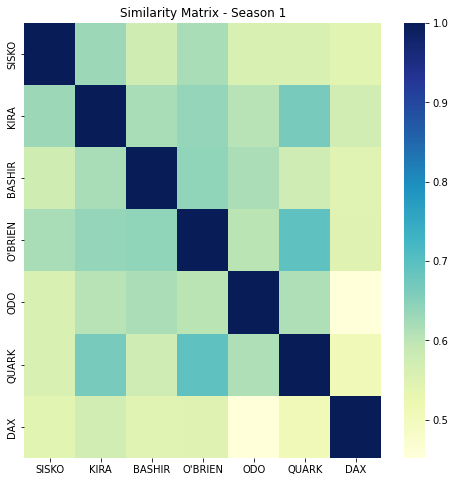


 --------------------   Season  2    --------------------


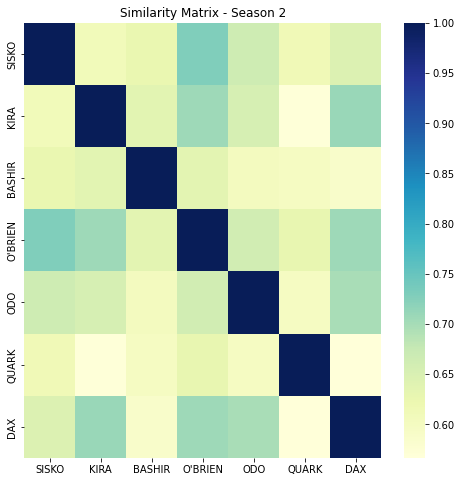


 --------------------   Season  3    --------------------


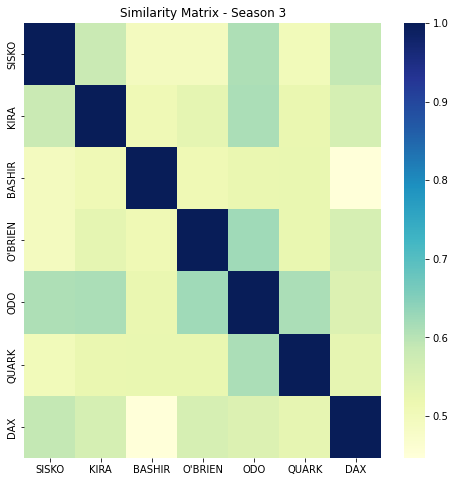


 --------------------   Season  4    --------------------


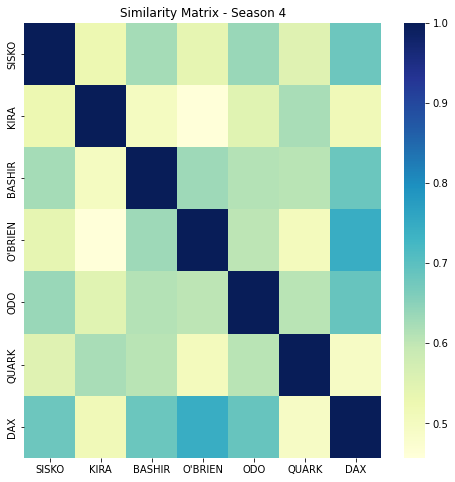


 --------------------   Season  5    --------------------


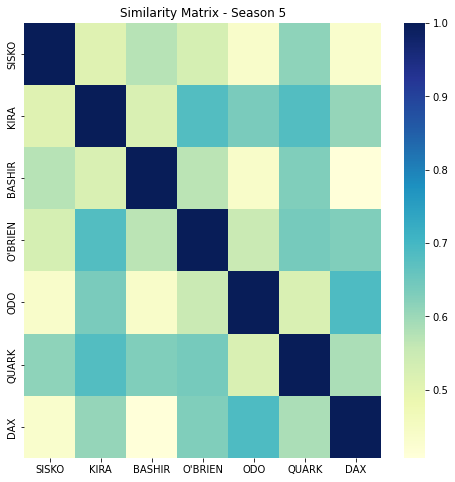


 --------------------   Season  6    --------------------


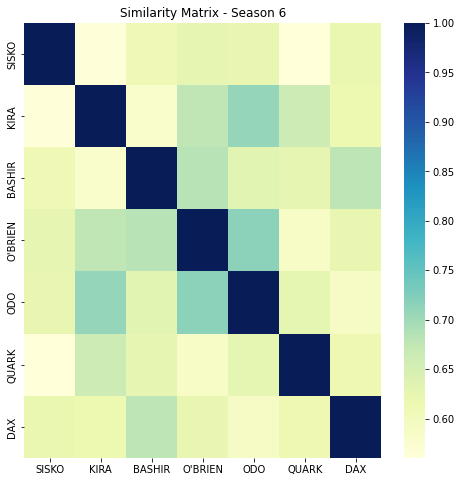


 --------------------   Season  7    --------------------


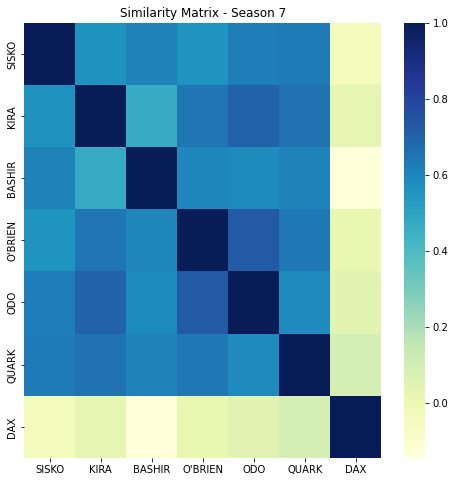

In [236]:
# -------------------------------    Season 1    ----------------------------------

season_episodes = episodes[0:20]
last_index = 20

print("-" * 20, "  Season 1  ", "-" * 20)

season_character_sentences_list = []

for character in list(character_corpus.keys()):

    character_lines = ''

    for episode in season_episodes:

        if df_all_series['DS9'][episode] is not np.NaN:

            for line in df_all_series['DS9'][episode][character]:

                character_lines += ' ' + line

    character_lines = character_lines.strip()
    character_lines_preprocessed = ' '.join(preprocess(character_lines))
    season_character_sentences_list.append(character_lines_preprocessed)

sbert_embeddings = sentence_embedder.encode(season_character_sentences_list, convert_to_tensor=True)


season_char_similarity = []

for i in range(len(season_character_sentences_list)):
    row = []
    for j in range(len(season_character_sentences_list)):
        row.append(util.pytorch_cos_sim(sbert_embeddings[i], sbert_embeddings[j]).item())
    season_char_similarity.append(row)

create_heatmap(season_char_similarity, 1)
# --------------------------------------------------------------------------------

# ------------------------ Rest of the Seasons (2 - 7) ---------------------------

for season in range(2, 8):

    print("\n", "-" * 20, "  Season ", str(season), "  ", "-" * 20)
    season_episodes = episodes[last_index : (last_index + 26)]
    last_index += 26

    season_character_sentences_list = []

    for character in list(character_corpus.keys()):

        character_lines = ''

        for episode in season_episodes:

            if df_all_series['DS9'][episode] is not np.NaN:

                for line in df_all_series['DS9'][episode][character]:

                    character_lines += ' ' + line

        character_lines = character_lines.strip()
        character_lines_preprocessed = ' '.join(preprocess(character_lines))
        season_character_sentences_list.append(character_lines_preprocessed)

    sbert_embeddings = sentence_embedder.encode(season_character_sentences_list, convert_to_tensor=True)


    season_char_similarity = []

    for i in range(len(season_character_sentences_list)):
        row = []
        for j in range(len(season_character_sentences_list)):
            row.append(util.pytorch_cos_sim(sbert_embeddings[i], sbert_embeddings[j]).item())
        season_char_similarity.append(row)

    create_heatmap(season_char_similarity, season)


## Conclusions

#### As we can observe from the heatmap of the similarity matrices for the main characters, the similarities are lower in the first season, signifying that the characters are new and unbiased and not influenced by the others. But with increasing seasons, we notice a gradual shift towards **higher similarities** between the characters, with Season 4 and Season 5 showing significantly higher average similarities. This indicates that the characters themselves begins to influence the scriptwriting as the show progresses. 

#### This is an interesting observation.

#### Lastly, the last season, i.e. **Season 7** shows an abnormally high degree of similarity between the characters, except DAX. This could be due to the following reasons:
- Since we do not have the episode scripts from the last 3 episodes, our embeddings of the dialogues are not as accurate.
- Less participation of the main characters during the last season, i.e. some dying off, eliminated, outcast etc. 
- The entirety of Season 7 focusing on a limited set of plot concepts, causing heavy similarities between the dialogues of the main characters. 

# Question 6. If you had more time, what would you do with this data?

### If I had more time, I would try to model the interactions between some of the important characters in the show by finding out the top supporting characters each of them share scenes with, most frequently. Building a **connected graph** of these scene associations with the characters being vertices and the strengths of the edges being proportional to the screen time shared between any 2 of them, would allow deeper understanding of the substructures of the different scenes, settings and moods of the movie in conjunction with the topics covered by each character. 

### Understanding these structures in the Character Interaction Graph would be like knowing the fundamental premises of the series without actually watching it !